# **Chem277B: Machine Learning Algorithms**

## Homework assignment #8: Convolutional Neural Networks

In [2]:
import numpy as np 
import pandas as pd
import math 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import SGD, Adam
from sklearn.model_selection import train_test_split, KFold
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import cycle, islice
from pylab import *
import seaborn as sns
from functools import wraps
from time import time
import random
from tqdm import tqdm
import warnings
import torchvision
from torchvision import transforms

sns.set()

## 1. **Convolutional Neural Networks applied to classification**.

###(a) 
From HW7, our initial input MNIST input data is 32 * 32 * 1 array.

(ai) With a convolution filter size of 2x2, number of filters 33, stride of 2, padding of 0.

The output height and width are calculated using the formula: 

$O = (I - K + 2P)/S + 1$

where O is the output dimension, I is the input size, K is the filter size, P is the padding, and S is the stride.

So: $O = (32 - 2 + 2*0)/2 + 1 = 16$

The output dimensionality is $16 * 16 * 33$.

(aii) With a convolution filter size of 3x3, number of filters 55, stride of 1, padding of 1.

$O = (16 - 3 + 2*1)/1 + 1 = 16$

The output dimensionality is $16 * 16 * 55$.

(aiii) With a convolution filter size of 3x3, number of filters 77, stride of 1, padding of 1. Followed by a Max Pooling with filter size of 2x2 and stride 2.

We first calculate the dimensionality after convolution filter.

$O = (16 - 3 + 2*1)/1 + 1 = 16$

So the output dimensionality after this step is $16 * 16 * 77$.

For the max pooling layer, the output height and width can be calculated with the equation:

$O = (I - K)/S + 1$

where O is the output size, I is the input size, K is the filter size, and S is the stride.

So $O = (16 - 2)/2 + 1 = 8$

The final output dimension is $8 * 8 * 77$.

###(b) 
Given that the input MNIST dataset has RGB values, the input data dimension is a $32 * 32 * 3$ array. The calculation steps are essentially the same as in (a).

(bi) The output dimension is $16 * 16 * 33$.

(bii) The output dimension after convolution is $16 * 16 * 55$. After max pooling is $14 * 14 * 55$.

(biii) The output dimension after convolution is $14 * 14 * 77$. After max pooling is $7 * 7 * 77$.

###(C)
We first load the mnist.pkl data and use the normalization function we developed last time to parse the data.

In [4]:
# First load the mnist data and convert all elements into lists / arrays
mnist = list(pd.read_pickle('mnist.pkl'))
mnist[0] = list(mnist[0])
mnist[1] = list(mnist[1])
train_X = mnist[0][0]
train_y = mnist[0][1]
test_X = mnist[1][0]
test_y = mnist[1][1]
print('Train: X=%s, y=%s' % (train_X.shape, train_y.shape))
print('Test: X=%s, y=%s' % (test_X.shape, test_y.shape))

# Define a function to normalize the training and testing data sets
def normalize_pixels(train_X, test_X):
    
    # First convert the dataset to floats
    train_X_norm = train_X.astype('float32')
    test_X_norm = test_X.astype('float32')
    
    # Find maximum values for all 60000 / 10000 pictures in train and test datasets
    # and broadcast to a (60000 / 10000, 32, 32) shape array
    train_X_max = np.broadcast_to(train_X.max(axis=(1,2))[:, np.newaxis, np.newaxis], (60000, 32, 32))
    test_X_max = np.broadcast_to(test_X.max(axis=(1,2))[:, np.newaxis, np.newaxis], (10000, 32, 32))
    
    # Normalize the datasets
    train_X_norm = train_X_norm / train_X_max
    test_X_norm = test_X_norm / test_X_max
    
    # Return the normalized datasets
    return train_X_norm, test_X_norm

# Normalize the datasets and confirm the data has been normalized
train_X_norm, test_X_norm = normalize_pixels(train_X, test_X)
print(train_X.sum(), train_X_norm.sum())
print(test_X.sum(), test_X_norm.sum())

Train: X=(60000, 32, 32), y=(60000,)
Test: X=(10000, 32, 32), y=(10000,)
1567298545 6148662.5
264923200 1039329.2


Next we import helper functions.

In [5]:
# Provided function to measure time
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

# Provided function to split data into small batches
def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

def dropped(m):
    if type(m) == nn.Dropout:
        m.train()

Next we implement the CNN to parse the mnist data

In [6]:
class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x,):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = optim.Adam(model.parameters(), learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop=False,
              l2=False, dropout_prob=0.5, augment=False, silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to tensor of correct shape and type here ###
        inputs = torch.Tensor(self.input_transform(inputs)).float().clone().detach() # inputs are (X (40000), 32, 32))
        outputs = torch.Tensor(outputs).long().clone().detach()  # outputs are (y (40000), ))
        val_inputs = torch.Tensor(self.input_transform(val_inputs)).float().clone().detach() # val_inputs are (X (20000), 32, 32))
        val_outputs = torch.Tensor(val_outputs).long().clone().detach()  # val_outputs are (y (20000), ))
        
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf

        ### apply data augmentation to the entire dataset ###
        if augment:
            transform = transforms.Compose([
            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ToTensor()
            ])
            inputs = torch.stack([transform(img) for img in inputs])
            val_inputs = torch.stack([transform(img) for img in val_inputs])
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0])) # range(40000)
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = self.model(batch_input)
                loss = F.cross_entropy(batch_predictions, batch_output)
                
                if dropout_prob > 0:
                    self.model.apply(dropped) # apply dropout to the model

                if l2:
                    ### Compute the loss with L2 regularization ###
                    l2_lambda = 1e-5
                    l2_reg = torch.tensor(0.)
                    for param in self.model.parameters():
                        l2_reg += torch.norm(param)
                    loss += l2_lambda * l2_reg

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                ### Compute epoch_loss and epoch_acc
                epoch_loss += loss.item() * batch_importance
                epoch_acc += (batch_predictions.argmax(dim=1) == batch_output).float().mean().item() * batch_importance

            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()

        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """
        with torch.no_grad():
            inputs = torch.tensor(inputs).float().clone().detach()
            outputs = torch.tensor(outputs).long().clone().detach()
            outputs_pred = self.model(inputs)
            losses = F.cross_entropy(outputs_pred, outputs)
            acc = torch.mean((torch.argmax(outputs_pred, dim=1) == outputs).float())
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

Next is to implement a CNN for the data training. The requirements are:

Start with one convolutional layer with a 5x5 kernel, with stride of 1, zero-padding of size 2, and 3 output channels. Flatten the resulting feature maps and add a second layer of fully connected (FC) layer to the 10- neuron output layer. Use ReLU as your activation function. Use the ADAM optimizer with learning rate of 1e-3, batchsize of 128, and 30 epochs.

Fortunately, after adding L2 regularization and dropout, the predictation accuracy increased to close 0.9.

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn = nn.Conv2d(in_channels=1, out_channels=3,\
                              kernel_size=5, stride=1, padding=2)
        self.fc = nn.Linear(3*32*32, 10)

    def forward(self, x):
        # reshape the data to a 4D tensor
        x = x.view(-1,1,32,32)
        x = F.relu(self.cnn(x))
        x = x.view(-1, 3*32*32)
        x = F.relu(self.fc(x))
        return x

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-6-b612d8dd6400>:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).float().clone().detach()
<ipython-input-6-b612d8dd6400>:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).long().clone().detach()
  3%|▎         | 1/30 [00:03<01:45,  3.64s/it]

Epoch 1/30 - Loss: 1.115 - Acc: 0.618
              Val_loss: 0.930 - Val_acc: 0.649


 37%|███▋      | 11/30 [00:43<01:16,  4.03s/it]

Epoch 11/30 - Loss: 0.774 - Acc: 0.680
              Val_loss: 0.791 - Val_acc: 0.678


 70%|███████   | 21/30 [01:23<00:37,  4.12s/it]

Epoch 21/30 - Loss: 0.759 - Acc: 0.682
              Val_loss: 0.784 - Val_acc: 0.678


func:'train'  took: 119.3039 sec


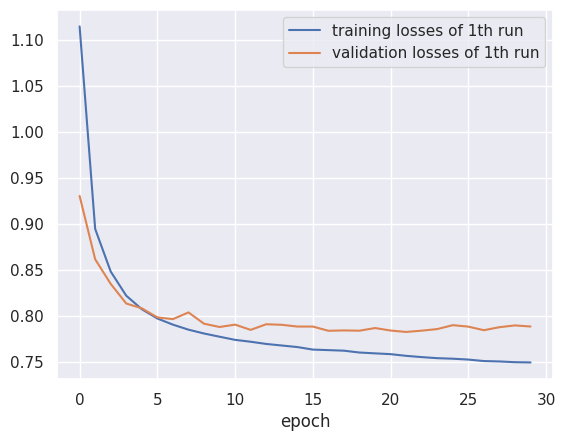

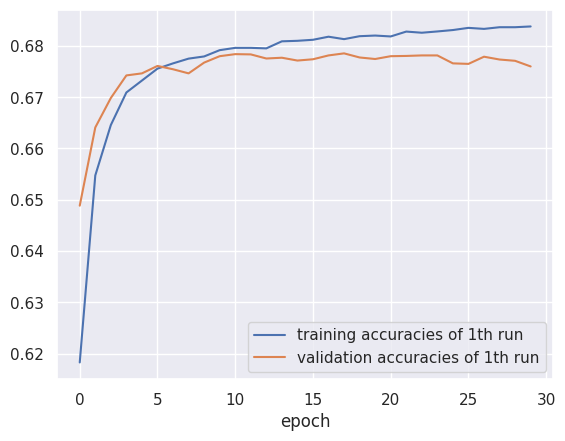

  3%|▎         | 1/30 [00:03<01:39,  3.44s/it]

Epoch 1/30 - Loss: 1.625 - Acc: 0.372
              Val_loss: 1.523 - Val_acc: 0.375


 37%|███▋      | 11/30 [00:40<01:10,  3.72s/it]

Epoch 11/30 - Loss: 1.204 - Acc: 0.489
              Val_loss: 1.232 - Val_acc: 0.482


 70%|███████   | 21/30 [01:18<00:35,  3.91s/it]

Epoch 21/30 - Loss: 1.188 - Acc: 0.492
              Val_loss: 1.231 - Val_acc: 0.482


func:'train'  took: 112.5854 sec


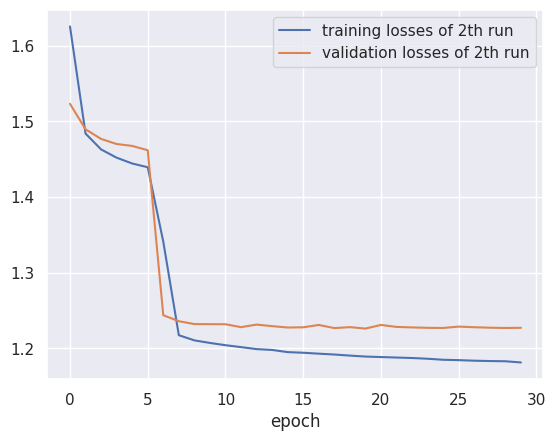

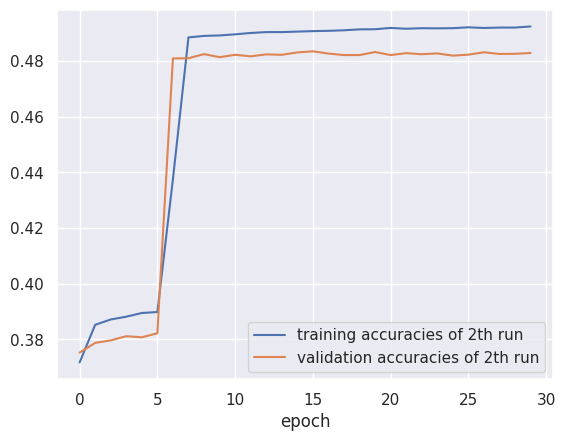

  3%|▎         | 1/30 [00:03<01:37,  3.36s/it]

Epoch 1/30 - Loss: 0.830 - Acc: 0.734
              Val_loss: 0.638 - Val_acc: 0.768


 37%|███▋      | 11/30 [00:44<01:20,  4.22s/it]

Epoch 11/30 - Loss: 0.509 - Acc: 0.796
              Val_loss: 0.526 - Val_acc: 0.791


 70%|███████   | 21/30 [01:25<00:37,  4.20s/it]

Epoch 21/30 - Loss: 0.487 - Acc: 0.801
              Val_loss: 0.519 - Val_acc: 0.793


func:'train'  took: 123.3978 sec


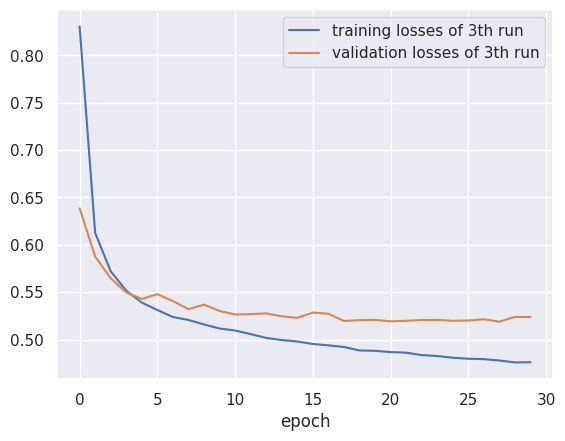

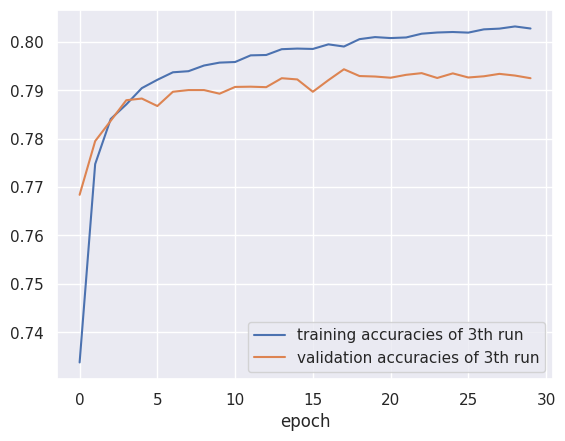

In [15]:
# Split the dataset into 3-fold training and validation sets
kf = KFold(n_splits=3, shuffle=True, random_state=1)
i = 0
for train_index, val_index in kf.split(train_X_norm, train_y):
    X_train, X_val = train_X_norm[train_index], train_X_norm[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    cnn = CNN()
    trainer = Trainer(cnn, "adam", 1e-3, 30, 128, input_transform=lambda x: x)

    training_result = trainer.train(X_train, y_train, X_val, y_val, early_stop=False, l2=True, dropout_prob=0.1, augment=False, silent=False)
    
    losses = training_result['losses']
    accuracies = training_result['accuracies']
    val_losses = training_result['val_losses']
    val_accuracies = training_result['val_accuracies']

    # Plot the training losses and accuracies of the i+1th run
    plt.plot(losses, label = f"training losses of {i+1}th run")
    plt.plot(val_losses, label = f"validation losses of {i+1}th run")
    plt.legend()
    plt.xlabel('epoch')
    plt.show()
    plt.plot(accuracies, label = f"training accuracies of {i+1}th run")
    plt.plot(val_accuracies, label = f"validation accuracies of {i+1}th run")
    plt.legend()
    plt.xlabel('epoch')
    plt.show()

    i+=1


###(d)
Using the newly built convolutional network, I was able to achieve very good prediction accuracies. On the test data set the accuracy is 0.99.

In [16]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=10, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = nn.Flatten()(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-6-b612d8dd6400>:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).float().clone().detach()
<ipython-input-6-b612d8dd6400>:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).long().clone().detach()
  3%|▎         | 1/30 [00:18<09:09, 18.95s/it]

Epoch 1/30 - Loss: 0.344 - Acc: 0.899
              Val_loss: 0.124 - Val_acc: 0.962


 37%|███▋      | 11/30 [03:05<05:13, 16.49s/it]

Epoch 11/30 - Loss: 0.012 - Acc: 0.996
              Val_loss: 0.044 - Val_acc: 0.989


 70%|███████   | 21/30 [05:49<02:27, 16.36s/it]

Epoch 21/30 - Loss: 0.008 - Acc: 0.997
              Val_loss: 0.058 - Val_acc: 0.988


func:'train'  took: 495.3097 sec


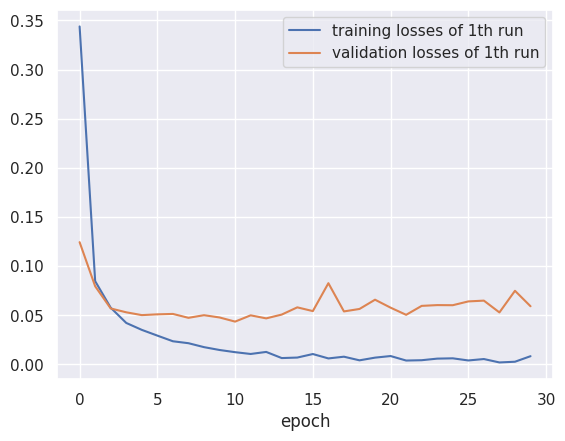

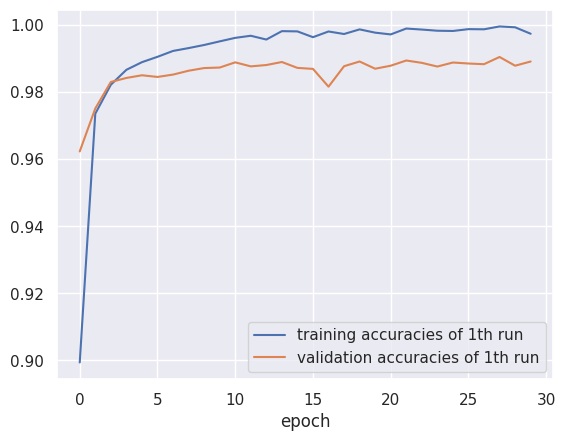

  3%|▎         | 1/30 [00:16<07:55, 16.40s/it]

Epoch 1/30 - Loss: 0.357 - Acc: 0.895
              Val_loss: 0.114 - Val_acc: 0.965


 37%|███▋      | 11/30 [03:00<05:10, 16.32s/it]

Epoch 11/30 - Loss: 0.015 - Acc: 0.995
              Val_loss: 0.066 - Val_acc: 0.983


 70%|███████   | 21/30 [05:42<02:25, 16.15s/it]

Epoch 21/30 - Loss: 0.006 - Acc: 0.998
              Val_loss: 0.058 - Val_acc: 0.989


func:'train'  took: 486.2293 sec


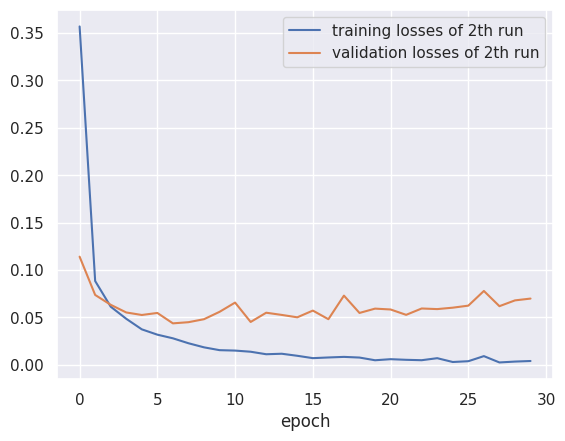

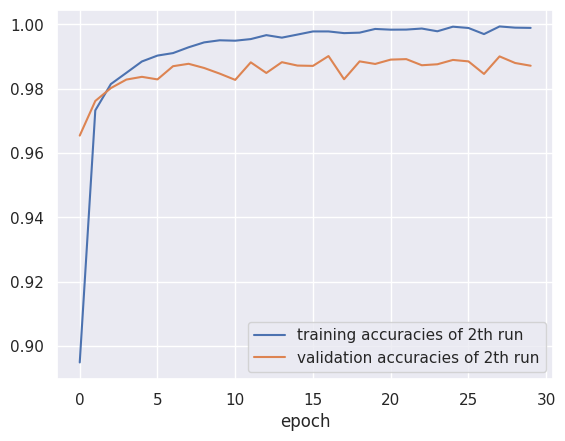

  3%|▎         | 1/30 [00:16<07:58, 16.50s/it]

Epoch 1/30 - Loss: 0.341 - Acc: 0.906
              Val_loss: 0.102 - Val_acc: 0.970


 37%|███▋      | 11/30 [03:00<05:10, 16.36s/it]

Epoch 11/30 - Loss: 0.013 - Acc: 0.996
              Val_loss: 0.045 - Val_acc: 0.988


 70%|███████   | 21/30 [05:43<02:25, 16.13s/it]

Epoch 21/30 - Loss: 0.009 - Acc: 0.997
              Val_loss: 0.046 - Val_acc: 0.990


func:'train'  took: 487.6661 sec


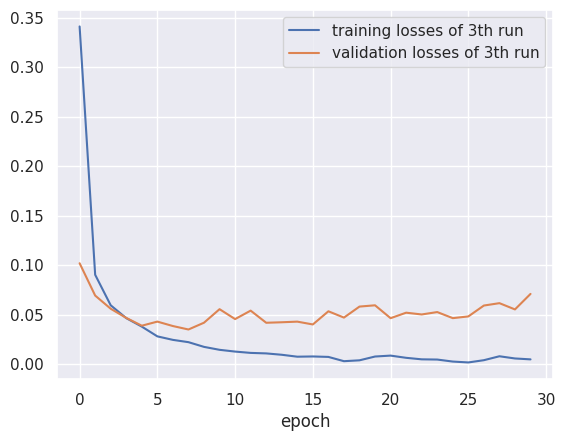

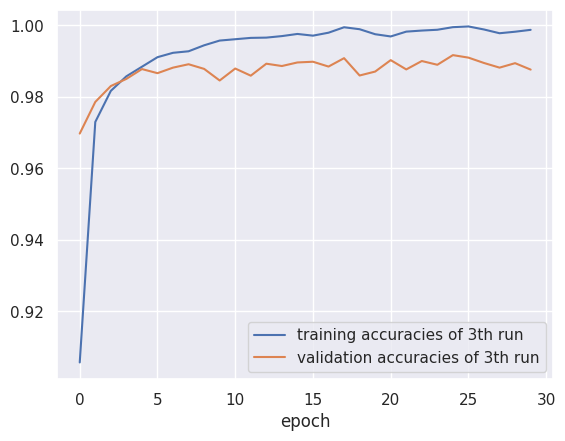

In [17]:
# Split the dataset into 3-fold training and validation sets
kf = KFold(n_splits=3, shuffle=True, random_state=1)
i = 0
for train_index, val_index in kf.split(train_X_norm, train_y):
    X_train, X_val = train_X_norm[train_index], train_X_norm[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    dnn = DeepCNN()
    trainer = Trainer(dnn, "adam", 1e-3, 30, 128, input_transform=lambda x: x)

    training_result = trainer.train(X_train, y_train, X_val, y_val, early_stop=False, l2=True, dropout_prob=0.1, augment=False, silent=False)
    
    losses = training_result['losses']
    accuracies = training_result['accuracies']
    val_losses = training_result['val_losses']
    val_accuracies = training_result['val_accuracies']

    # Plot the training losses and accuracies of the i+1th run
    plt.plot(losses, label = f"training losses of {i+1}th run")
    plt.plot(val_losses, label = f"validation losses of {i+1}th run")
    plt.legend()
    plt.xlabel('epoch')
    plt.show()
    plt.plot(accuracies, label = f"training accuracies of {i+1}th run")
    plt.plot(val_accuracies, label = f"validation accuracies of {i+1}th run")
    plt.legend()
    plt.xlabel('epoch')
    plt.show()

    i+=1


In [18]:
trainer.evaluate(test_X_norm, test_y)

Accuracy: 0.990


(tensor(0.0470), tensor(0.9898))